In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
!pip3 install torchsummary

In [1]:
import torch
import numpy as np
from torchsummary import summary
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
  print("The GPU is available for training")
else:
    print("The GPU is not available for training")

The GPU is available for training


In [2]:
#loading the datasets
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)



Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [0]:
valid_size = 0.2# 20% of the training data is taken for the testing
num_train = len(train_data)
indices = list(range(num_train))
# print(indices)
np.random.shuffle(indices)#shuffling is done so as to get a mixed training and the testing sample
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [0]:
#this will create a training and the testing batches for the model
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=20,sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=20,sampler=valid_sampler)
test_loader = DataLoader(test_data,batch_size=20)

In [0]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [0]:
#visualize the training data
dataiter = iter(train_loader)#making the iterator out of train_loader
images, labels = dataiter.next()#takinng the next batch
images = images.numpy() # convert images to numpy for display

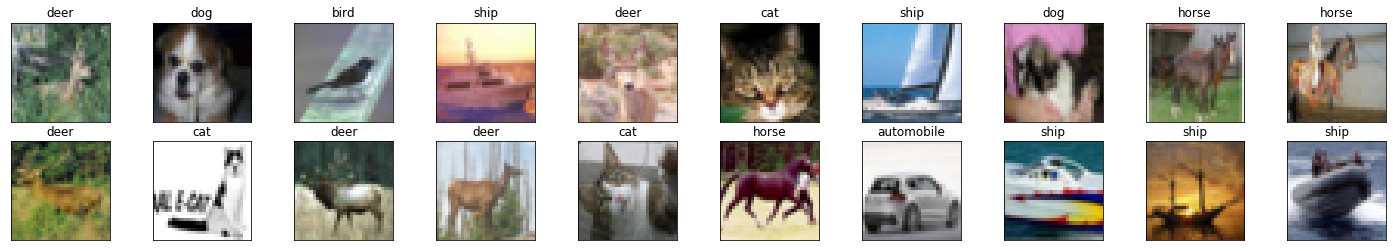

In [9]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])#rows,columns
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
# refer:  https://pytorch.org/docs/stable/nn.html#conv2d

'''
OUTPUT SIZE =  (W−F+2P)/S+1.

W = INPUT SIZE
F = KERNAL SIZE
P = PADDING
S = STRIDE
'''

#define the network
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # convolutional layer (sees 32x32x3 image tensor)
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    # convolutional layer (sees 16x16x16 tensor)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    # convolutional layer (sees 8x8x32 tensor)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    # max pooling layer
    self.pool = nn.MaxPool2d(2, 2)
    # linear layer (64 * 4 * 4 -> 500)
    self.fc1 = nn.Linear(64 * 4 * 4, 500)
    # linear layer (500 -> 10)
    self.fc2 = nn.Linear(500, len(classes))
    # dropout layer (p=0.25)
    self.dropout = nn.Dropout(0.25)


  def forward(self,x):
    '''
    first block
    '''
    x = self.conv1(x)#<--(32,32,3) (3x3) -->(32,32,16)
    x = F.relu(x)
    x = self.pool(x)#<--(32,32,16) !(2x2)! -->(16,16,16)
    '''
    second block
    '''
    x = self.conv2(x)#<--(16,16,16) (3x3) -->(16,16,32)
    x = F.relu(x)
    x = self.pool(x)#<--(16,16,32) !(2x2)! -->(8,8,32)
    '''
    third block
    '''
    x = self.conv3(x)#<--(8,8,32) (3x3) -->(8,8,64)
    x = F.relu(x)
    x = self.pool(x)#<--(8,8,64) !(2x2)! -->(4,4,64)
    '''
    fully connected layer
    '''
    x = x.view(-1,64*4*4)#the output size will be (1,64*4*4)
    x = self.dropout(x)
    x = self.fc1(x)#<--(1,1024) -->(1,500)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)#<--(1,500) -->(1,10)
    return x

In [0]:
model = Net()#setting the model object

In [14]:
#transferring the model to the GPU
if train_on_gpu:
  model.cuda()
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
           Dropout-7                 [-1, 1024]               0
            Linear-8                  [-1, 500]         512,500
           Dropout-9                  [-1, 500]               0
           Linear-10                   [-1, 10]           5,010
Total params: 541,094
Trainable params: 541,094
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 2.06
Estimated T

In [0]:
#defining the loss function and the optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [17]:
#training the network
epochs = 30
valid_loss_min = np.inf #setting the validation loss to infinity

for epoch in range(1,epochs+1):
  train_loss = 0.0
  valid_loss = 0.0

  model.train()#setting the model to train mode

  for data,target in train_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()

    optimizer.zero_grad()#clearing out any accumulated gradients
    output = model(data)
    loss = criterion(output,target)
    loss.backward()
    optimizer.step()
    train_loss+= loss.item()*data.size(0)

#Validation mode
  model.eval()#setting the model to eval mode as the model is evaluated on the validation set 
  for data,target in valid_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output,target)
    valid_loss += loss.item()*data.size(0)

    #for calculating the average loss
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
      torch.save(model.state_dict(), 'model_cifar.pt')
      valid_loss_min = valid_loss
    


Streaming output truncated to the last 5000 lines.
Epoch: 21 	Training Loss: 0.000000 	Validation Loss: 0.001889
Epoch: 21 	Training Loss: 0.000000 	Validation Loss: 0.001717
Epoch: 21 	Training Loss: 0.000000 	Validation Loss: 0.001505
Epoch: 21 	Training Loss: 0.000000 	Validation Loss: 0.001990
Epoch: 21 	Training Loss: 0.000000 	Validation Loss: 0.001659
Epoch: 21 	Training Loss: 0.000000 	Validation Loss: 0.000732
Epoch: 21 	Training Loss: 0.000000 	Validation Loss: 0.001882
Epoch: 21 	Training Loss: 0.000000 	Validation Loss: 0.000891
Epoch: 21 	Training Loss: 0.000000 	Validation Loss: 0.001164
Epoch: 21 	Training Loss: 0.000000 	Validation Loss: 0.001988
Epoch: 21 	Training Loss: 0.000000 	Validation Loss: 0.001071
Epoch: 21 	Training Loss: 0.000000 	Validation Loss: 0.000645
Epoch: 21 	Training Loss: 0.000000 	Validation Loss: 0.001390
Epoch: 21 	Training Loss: 0.000000 	Validation Loss: 0.001736
Epoch: 21 	Training Loss: 0.000000 	Validation Loss: 0.001879
Epoch: 21 	Training

In [18]:
#loading the saved model
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [20]:
#Testing the network
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
batch_size = 20

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i],np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.770426

Test Accuracy of airplane: 81% (819/1000)
Test Accuracy of automobile: 88% (882/1000)
Test Accuracy of  bird: 60% (608/1000)
Test Accuracy of   cat: 58% (587/1000)
Test Accuracy of  deer: 73% (739/1000)
Test Accuracy of   dog: 65% (653/1000)
Test Accuracy of  frog: 72% (729/1000)
Test Accuracy of horse: 79% (795/1000)
Test Accuracy of  ship: 84% (847/1000)
Test Accuracy of truck: 79% (797/1000)

Test Accuracy (Overall): 74% (7456/10000)


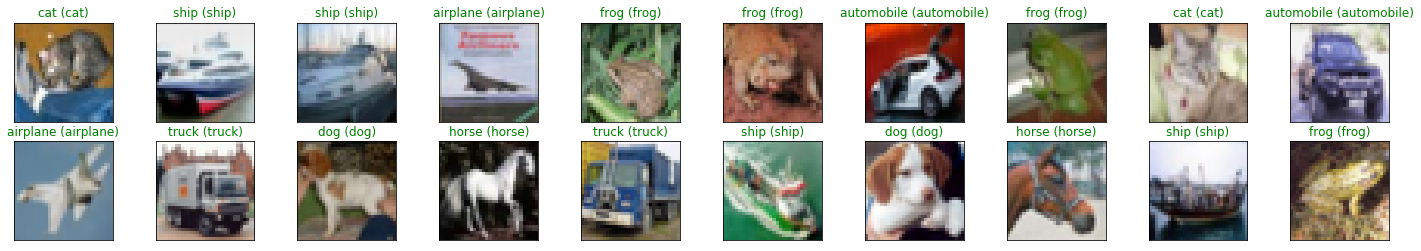

In [21]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))